In [1]:
import pymc3 as pm
from pymc3.gp.util import plot_gp_dist
import theano.tensor as tt
import numpy as np
import pandas as pd
from sklearn import datasets
import matplotlib.pyplot as plt
%matplotlib inline

WARNING (theano.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
C:\Users\smrut\Anaconda3\lib\site-packages\theano\configdefaults.py:560: UserWarning: DeprecationWarning: there is no c++ compiler.This is deprecated and with Theano 0.11 a c++ compiler will be mandatory
  warnings.warn("DeprecationWarning: there is no c++ compiler."
WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


# simple model

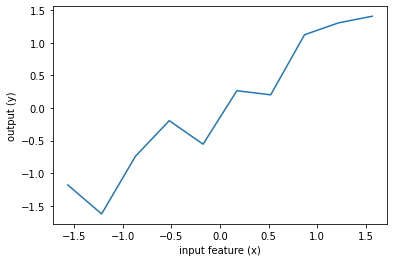

In [15]:
X = np.linspace(0, 1, 10)[:, None]
y = 3*X[:,0] + np.random.rand(10)
X = (X-X.mean(axis=0))/X.std(axis=0)
y = (y-y.mean(axis=0))/y.std(axis=0)

plt.plot(X, y)
plt.xlabel("input feature (x)")
plt.ylabel("output (y)")
plt.show();

In [16]:
with pm.Model() as model:
    ℓ = pm.Gamma("ℓ", alpha=2, beta=1)
    η = pm.HalfCauchy("η", beta=5)
    cov_func = η**2 * pm.gp.cov.ExpQuad(1, ls=ℓ)
    gp = pm.gp.Latent(cov_func=cov_func)
    f = gp.prior("f", X=X)
    σ = pm.HalfCauchy("σ", beta=5)
    y_obs = pm.Normal("y_obs", mu=f, sigma=σ, observed=y)
    trace = pm.sample(1000, cores=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [σ, f_rotated_]
Sampling 2 chains, 2 divergences: 100%|██████████| 3000/3000 [00:50<00:00, 59.41draws/s]
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.


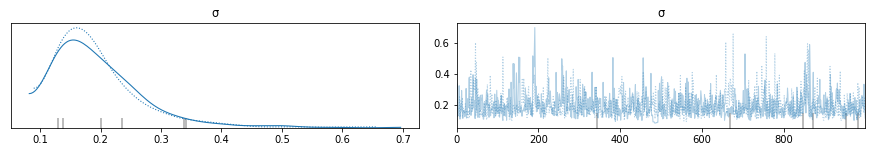

In [7]:
pm.traceplot(trace, var_names=["ℓ", "η","σ"]);

In [17]:
# 200 new values from x=0 to x=15
n_new = 30
X_new = np.linspace(0, 3, n_new)[:,None]

# add the GP conditional to the model, given the new X values
with model:
    f_pred = gp.conditional("f_pred", X_new)

# Sample from the GP conditional distribution
with model:
    pred_samples = pm.sample_posterior_predictive(trace, vars=[f_pred], samples=1000)

C:\Users\smrut\Anaconda3\lib\site-packages\pymc3\sampling.py:1247: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "
100%|██████████| 1000/1000 [00:08<00:00, 114.69it/s]


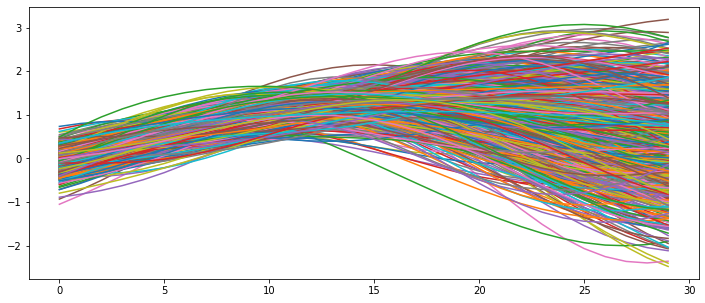

In [18]:
fig = plt.figure(figsize=(12,5)); ax = fig.gca()
plt.plot(pred_samples["f_pred"].T);

# iris dataset

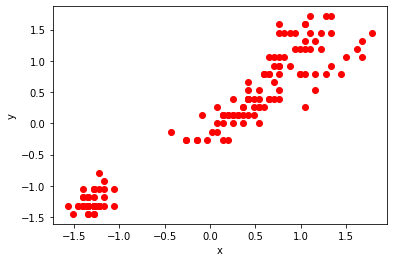

In [29]:
iris = datasets.load_iris()
X = iris.data
X = (X-X.mean(axis=0))/X.std(axis=0)
np.corrcoef(X.T)
x, y = X[:,2][:,None], X[:,3]
plt.scatter(x,y, color="red")
plt.xlabel("x")
plt.ylabel("y")
plt.show()

In [31]:
with pm.Model() as model:
    ℓ = 1
    η = 1
    cov_func = η**2 * pm.gp.cov.ExpQuad(1, ls=ℓ)
    gp = pm.gp.Latent(cov_func=cov_func)
    f = gp.prior("f", X=x)
    σ = pm.HalfCauchy("σ", beta=5)
    ν = pm.Gamma("ν", alpha=2, beta=0.1)
    y_obs = pm.StudentT("y_obs", mu=f, lam=1.0/σ, nu=ν, observed=y)
    trace = pm.sample(1000, cores=1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [ν, σ, f_rotated_]
Sampling chain 1, 0 divergences: 100%|██████████| 1500/1500 [40:59<00:00,  1.64s/it] 


In [57]:
dx = pd.DataFrame(np.hstack([x, trace["f"].T])).sort_values(by=[0])
sample = dx.iloc[:,1:].values.T
data = dx.iloc[:,0:1].values

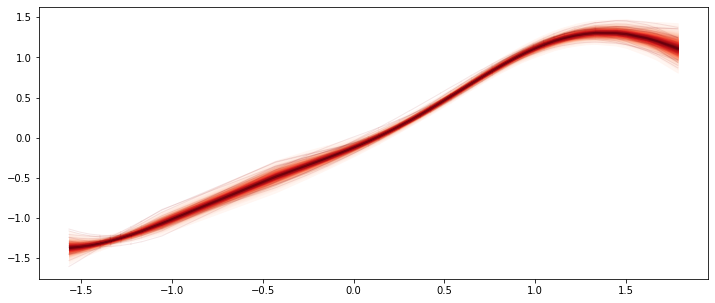

In [58]:
fig = plt.figure(figsize=(12,5)); ax = fig.gca()
plot_gp_dist(ax, sample, data);